In [1]:
from policy_epidemic_model_code import *
from jupyterWidgets import *

import numpy as np
import importlib
import matplotlib.pyplot as plt

import pandas as pd

In [65]:
epidemic_simulators = {}
policy_controls = {}

In [55]:
class Policy_template():
    
    def __init__(self, lockdown_policy_control_days, lockdown_policy_lower_limits,
                 lockdown_policy_upper_limits, testing_policy_control_days, testing_policy_lower_limits,
                 testing_policy_upper_limits):
        self.lockdown_policy_control_days = lockdown_policy_control_days
        self.lockdown_policy_lower_limits = lockdown_policy_lower_limits
        self.lockdown_policy_upper_limits = lockdown_policy_upper_limits
        self.testing_policy_control_days = testing_policy_control_days
        self.testing_policy_lower_limits = testing_policy_lower_limits
        self.testing_policy_upper_limits = testing_policy_upper_limits
        
            
            

In [56]:
ttest_pol = Policy_template([1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600], list(0.5 * np.ones(15)), list(1.0 * np.ones(15)), [1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600], list(np.zeros(15)), list(0.2 * np.ones(15)))

In [57]:
ttest_pol.lockdown_policy_control_days

[1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]

In [60]:
ttest_pol.lockdown_policy_control_days = [1, 2, 3, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]

In [58]:
ttest_pol.update_policy(lockdown_policy_control_days=[1, 2, 3, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600])

arg:  lockdown_policy_control_days
kwargs[arg]:  [1, 2, 3, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
self.arg.  [1, 2, 3, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]


In [61]:
ttest_pol.lockdown_policy_control_days

[1, 2, 3, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]

In [66]:
# Tools for building optimization runs based on params.

def create_policy(policy_control_times, policy_control_values):
    policy = {} # this will hold the policy in format suitable for input to the epidemic model
    #print("times: ", policy_control_times)
    #print("values: ", policy_control_values)
            
    for (i, t) in enumerate(policy_control_times):
        policy[t] = policy_control_values[i]
        
    return policy

# Run generator

# NOTE: default values for all adjustable run parameters defined in function definition below:
def create_simu_run(ksi_base=0,
    A_rel=0.5, 
    r_AP=0,
    d_vaccine=800,
    rel_rho=1.0,
    delta_param = 5,
    omegaR_param = 14,
    pii_D=0.01,
    R_0=2.5,
    rel_lambda_param=0.5, 
    initial_infect=300,
    testing_rate=0.0,
    testing_sensitivity = 1.0,
    testing_specificity = 1.0,
    unknown_q_rate = 0.0,
    recovered_q_rate = 0.0,
    negative_q_rate = 0.0,
    positive_q_rate = 0.999,
    testing_cost=100,
    pop_size=28,
    n_offsprings=14,
    #sampling=get_sampling("real_random"),
    #crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    #mutation=get_mutation("real_pm", eta=15),
    #eliminate_duplicates=True,
    #filename = "foo",
    #termination = get_termination("n_gen", 100),
    lockdown_policy_control_days = [1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    lockdown_policy_lower_limits = list(0.5*np.ones(15)), # can't use len(l_p_c_d) within function param def
    lockdown_policy_upper_limits = list(1.0*np.ones(15)), # needs to be different from lower limit
    testing_policy_control_days = [1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    testing_policy_lower_limits = list(np.zeros(15)),
    testing_policy_upper_limits = list(0.2*np.ones(15))
              ):
    
    
    model = optimizable_corona_model(ksi_base, A_rel, r_AP, d_vaccine, rel_rho, delta_param, \
                 omegaR_param, pii_D, R_0, rel_lambda_param, initial_infect, testing_cost)
    
    model_case = {
        'tau_paramA'            : testing_rate,
        'test_sens'     : testing_sensitivity,
        'test_spec'     : testing_specificity,
        'ksi_U'           : (1+unknown_q_rate)**(1./model.Delta_time)-1,
        'ksi_P'           : (1+positive_q_rate)**(1./model.Delta_time)-1,
        'ksi_N'           : (1+negative_q_rate)**(1./model.Delta_time)-1,
        'ksi_R'           : (1+recovered_q_rate)**(1./model.Delta_time)-1,
        'r_U'           : (1+0.98)**(1./model.Delta_time)-1, # should be redundant!
        'r_P'           : (1+0.98)**(1./model.Delta_time)-1,
        'r_AP'          : 0.0,
        'r_N'           : (1+0.98)**(1./model.Delta_time)-1,
        'r_R'           : (1+0.999)**(1./model.Delta_time)-1,
        'd_start_exp': 0.,
        'experiment': "baseline_vaccine_tag"
    }
    
    policy_control = Policy_template(lockdown_policy_control_days, lockdown_policy_lower_limits,
                 lockdown_policy_upper_limits, testing_policy_control_days, testing_policy_lower_limits,
                 testing_policy_upper_limits)
    
   
    return model, model_case, policy_control
    

In [71]:
runs = {}
### ROMER CASE SCENARIOS ###
#------------------------------------------#

runs['romer']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05]
}

#------------------------------------------#

runs['romer_R0_4.0']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'R_0': 4.0, # set R0 to a higher value
}

# #------------------------------------------#

runs['romer_R0_4.0_sens_spec_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.75,
    'testing_specificity': 0.75,
    'R_0': 4.0, # set R0 to a higher value
}

#------------------------------------------#

runs['romer_6d_incubation']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'delta_param': 6
}

#------------------------------------------#

runs['romer_8d_incubation']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'delta_param': 8
}

#------------------------------------------#

runs['romer_8d_incubation_sens_spec_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'delta_param': 8,
    'testing_sensitivity': 0.75,
    'testing_specificity': 0.75
}


runs['romer_3d_delay']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_policy_control_days': [3, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
}

runs['romer_7d_delay']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_policy_control_days': [7, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
}

runs['romer_14d_delay']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_policy_control_days': [14, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
}



runs['romer_sens_spec_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.75,
    'testing_specificity': 0.75,
}

#------------------------------------------#

runs['romer_sens_spec_085']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.85,
    'testing_specificity': 0.85,
}

#------------------------------------------#

runs['romer_sens_spec_090']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.90,
    'testing_specificity': 0.90,
}

#------------------------------------------#

runs['romer_sens_spec_095']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.95,
    'testing_specificity': 0.95,
}

#------------------------------------------#

runs['romer_R0_4.0_sens_spec_085']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.85,
    'testing_specificity': 0.85,
    'R_0': 4.0, # set R0 to a higher value
}

#------------------------------------------#

runs['romer_R0_4.0_sens_spec_090']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.90,
    'testing_specificity': 0.90,
    'R_0': 4.0, # set R0 to a higher value
}

#------------------------------------------#

runs['romer_R0_4.0_sens_spec_095']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.95,
    'testing_specificity': 0.95,
    'R_0': 4.0, # set R0 to a higher value
}

### LOCKDOWN OPTIMIZATION CASE SCENARIOS ###

#------------------------------------------#

runs['base_case_lockdown_opt']={
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}

#------------------------------------------#

runs['base_case_lockdown_opt_R0_4.0']={
    'R_0': 4.0,
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}

#------------------------------------------#

runs['base_case_lockdown_opt_with_limited_general_testing']={
    'testing_rate': 0.005,
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}

#------------------------------------------#

runs['base_case_lockdown_opt_with_limited_imperfect(0.75)_general_testing']={
    'testing_rate': 0.005,
    'testing_sensitivity': 0.75,
    'testing_specificity': 0.75,
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}

#------------------------------------------#

runs['base_case_lockdown_opt_3d_delay']={
    'lockdown_policy_control_days': [3, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}

runs['base_case_lockdown_opt_7d_delay']={
    'lockdown_policy_control_days': [7, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}

runs['base_case_lockdown_opt_14d_delay']={
    'lockdown_policy_control_days': [14, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}



runs['base_case_6d_incubation']={
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05],
    'delta_param': 6,
}


runs['base_case_8d_incubation']={
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05],
    'delta_param': 8,
}


In [ ]:
runs['romer_sens_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_sensitivity': 0.75,
}

runs['romer_spec_075']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_specificity': 0.75,
}

runs['base_case_lockdown_opt_28d_delay']={
    'lockdown_policy_control_days': [28, 29, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
    'testing_policy_control_days': [10000],   # no adjustments to testing policy
    'testing_policy_lower_limits': [0.0],
    'testing_policy_upper_limits': [0.05]
}

runs['romer_28d_delay']={
    'lockdown_policy_control_days': [10000],   # no adjustments to testing policy
    'lockdown_policy_lower_limits': [0.0],
    'lockdown_policy_upper_limits': [0.05],
    'testing_policy_control_days': [28, 29, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600],
}

In [72]:
for run in runs:
    model, model_case, policy_control = create_simu_run(**runs[run])

    epidemic_simulators[run] = (model, model_case)
    policy_controls[run] = policy_control

In [68]:
runs.keys()

dict_keys(['romer_R0_4.0_sens_spec_075', 'romer_R0_4.0_sens_spec_085', 'romer_R0_4.0_sens_spec_090', 'romer_R0_4.0_sens_spec_095', 'romer_R0_4.0', 'romer', 'base_case_lockdown_opt', 'base_case_lockdown_opt_R0_4.0', 'base_case_lockdown_opt_with_limited_general_testing', 'base_case_lockdown_opt_with_limited_imperfect(0.75)_general_testing'])

In [73]:
lowest_deaths_policy = {}
best_output_policy = {}
most_smooth_policy = {}
lowest_deaths_obj = {}
best_output_obj = {}
best_output_run_data = {}
lowest_deaths_run_data = {}
most_smooth_policy_run_data = {}


for run in runs:
    run_obj_df = pd.read_csv('active_results/'+run+'_objectives.csv', delimiter=',')
    run_policies_df = pd.read_csv('active_results/'+run+'_results.csv', delimiter=',')
    run_obj = run_obj_df.to_numpy()
    run_policies = run_policies_df.to_numpy()
    
    
    lowest_deaths_policy[run] = run_policies[np.argmin(run_obj[:,0]), :]
    lowest_deaths_obj[run] = run_obj[np.argmin(run_obj[:,0]), :]
    best_output_policy[run] = run_policies[np.argmin(run_obj[:,1]), :] # min because of -1 multiplier
    best_output_obj[run] = run_obj[np.argmin(run_obj[:,1]), :]
    
    best_output_run_ld_policy = create_policy(policy_controls[run].lockdown_policy_control_days, best_output_policy[run][0:len(policy_controls[run].lockdown_policy_control_days)])
    print("DEBUG:")
    print("run: ", run)
    print("testing days: ", policy_controls[run].testing_policy_control_days)
    print("testing policy: ", best_output_policy[run][len(policy_controls[run].lockdown_policy_control_days):len(best_output_policy[run])])
    
    best_output_run_test_policy = create_policy(policy_controls[run].testing_policy_control_days, best_output_policy[run][len(policy_controls[run].lockdown_policy_control_days):len(best_output_policy[run])])
    best_output_run_data[run] = epidemic_simulators[run][0].solve_case(epidemic_simulators[run][1], best_output_run_ld_policy, best_output_run_test_policy )
    
    lowest_deaths_run_ld_policy = create_policy(policy_controls[run].lockdown_policy_control_days, lowest_deaths_policy[run][0:len(policy_controls[run].lockdown_policy_control_days)])
    lowest_deaths_run_test_policy = create_policy(policy_controls[run].testing_policy_control_days, lowest_deaths_policy[run][len(policy_controls[run].lockdown_policy_control_days):len(lowest_deaths_policy[run])])
    lowest_deaths_run_data[run] = epidemic_simulators[run][0].solve_case(epidemic_simulators[run][1], lowest_deaths_run_ld_policy, lowest_deaths_run_test_policy )
    
    # Smoothest policy (least change between consecutive policy steps)
    change_measure = np.zeros(len(run_policies[:,1]))
    for p in range(1,len(run_policies[:,1])):
        for s, v in enumerate(run_policies[p,1:len(run_policies[p,:])]):
            change_measure[p] += abs(v-run_policies[p,s-1])
        #3print("change measure: ", change_measure)
    most_smooth_policy[run] = run_policies[np.argmin(change_measure),:]
    most_smooth_ld_policy = create_policy(policy_controls[run].lockdown_policy_control_days, most_smooth_policy[run][0:len(policy_controls[run].lockdown_policy_control_days)])
    most_smooth_test_policy = create_policy(policy_controls[run].testing_policy_control_days, most_smooth_policy[run][len(policy_controls[run].lockdown_policy_control_days):len(lowest_deaths_policy[run])])
    most_smooth_policy_run_data[run] = epidemic_simulators[run][0].solve_case(epidemic_simulators[run][1], most_smooth_ld_policy, most_smooth_test_policy )
            

DEBUG:
run:  romer
testing days:  [1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [0.19999999 0.19999999 0.2        0.14998414 0.00690999 0.15823892
 0.11325757 0.0303313  0.00105689 0.09614349 0.01921947 0.05659699
 0.12142384 0.1550317  0.18493645]
DEBUG:
run:  romer_R0_4.0
testing days:  [1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [0.2        0.2        0.19999997 0.02230323 0.16173124 0.19836372
 0.0609955  0.17395154 0.14567536 0.05888385 0.12767406 0.00101529
 0.08552852 0.08951347 0.12444242]
DEBUG:
run:  romer_R0_4.0_sens_spec_075
testing days:  [1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]
testing policy:  [4.52663602e-11 4.42354486e-14 3.83547217e-16 5.02224256e-02
 1.40289929e-01 1.19467711e-01 1.80280784e-01 5.08244010e-02
 4.04830170e-02 1.08194838e-02 1.89605591e-01 4.00580326e-04
 1.48410289e-01 1.97925140e-01 1.83376002e-01]
DEBUG:
run:  romer_6d_incubation
testing 

In [107]:
lowest_deaths_obj['romer_R0_4.0_sens_spec_075']

array([285.73736871,  -0.98626958, 103.60356324])

In [108]:
best_output_obj['romer_R0_4.0_sens_spec_075']

array([405.0665245 ,  -0.98713573, 127.406004  ])

In [88]:
lowest_deaths_run_data.keys()

dict_keys(['romer', 'romer_R0_4.0', 'romer_R0_4.0_sens_spec_075', 'romer_6d_incubation', 'romer_8d_incubation', 'romer_8d_incubation_sens_spec_075', 'romer_sens_spec_075', 'romer_3d_delay', 'romer_7d_delay', 'romer_14d_delay'])

In [71]:
time_steps = range(1, len(lowest_deaths_run_data['romer'][2])+1)
time_steps

range(1, 731)

In [72]:
print("most_smooth_policy: ", most_smooth_policy['romer'])
change_measure_ms = 0
for s, v in enumerate(most_smooth_policy['romer'][1:len(most_smooth_policy['romer'])]):
            change_measure_ms += abs(v-most_smooth_policy['romer'][s-1])
print("change measure: ", change_measure_ms)

most_smooth_policy:  [0.02674136 0.2        0.01580915 0.00415287 0.16689415 0.181234
 0.16343049 0.04925113 0.12629004 0.16925829 0.00041235 0.039656
 0.06997505 0.11655434 0.09385456 0.198568  ]
change measure:  1.336805819964046


In [73]:
print("lowest deaths policy: ", lowest_deaths_policy['romer'])
change_measure_ms = 0
for s, v in enumerate(lowest_deaths_policy['romer'][1:len(lowest_deaths_policy['romer'])]):
            change_measure_ms += abs(v-lowest_deaths_policy['romer'][s-1])
print("change measure: ", change_measure_ms)

lowest deaths policy:  [2.17475718e-03 1.99999998e-01 1.06877251e-01 1.70758736e-04
 1.58130757e-01 1.99029479e-01 1.87075140e-01 5.22779681e-02
 1.11484761e-01 1.94522207e-01 1.10988110e-02 1.73609426e-01
 3.24804444e-02 1.27058198e-01 9.52917175e-02 1.58417109e-01]
change measure:  1.273159138435672


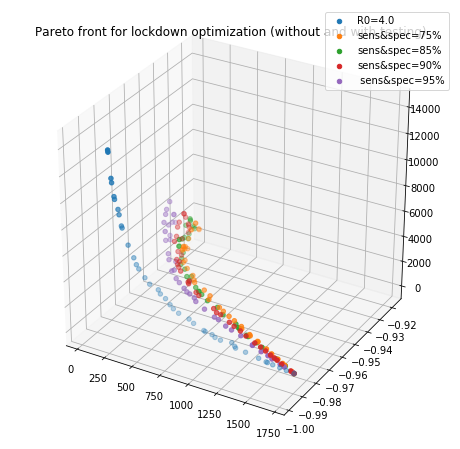

In [103]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk
#run_obj_df_bc = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_pt = pd.read_csv('active_results/romer_R0_4.0_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt75 = pd.read_csv('active_results/romer_R0_4.0_sens_spec_075_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt85 = pd.read_csv('active_results/romer_R0_4.0_sens_spec_085_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt90 = pd.read_csv('active_results/romer_R0_4.0_sens_spec_090_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt95 = pd.read_csv('active_results/romer_R0_4.0_sens_spec_095_objectives.csv', delimiter=',').to_numpy()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
ax.scatter(run_obj_df_bc_pt[:,0], run_obj_df_bc_pt[:,1], run_obj_df_bc_pt[:,2])
ax.scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,1], run_obj_df_bc_ipt75[:,2])
ax.scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,1], run_obj_df_bc_ipt85[:,2])
ax.scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,1], run_obj_df_bc_ipt90[:,2])
ax.scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,1], run_obj_df_bc_ipt95[:,2])

ax.legend(['R0=4.0', 'sens&spec=75%', 'sens&spec=85%', 'sens&spec=90%',' sens&spec=95%'])
plt.title("Pareto front for lockdown optimization (without and with testing)")
plt.savefig("active_results/pareto_example.png", dpi=150)



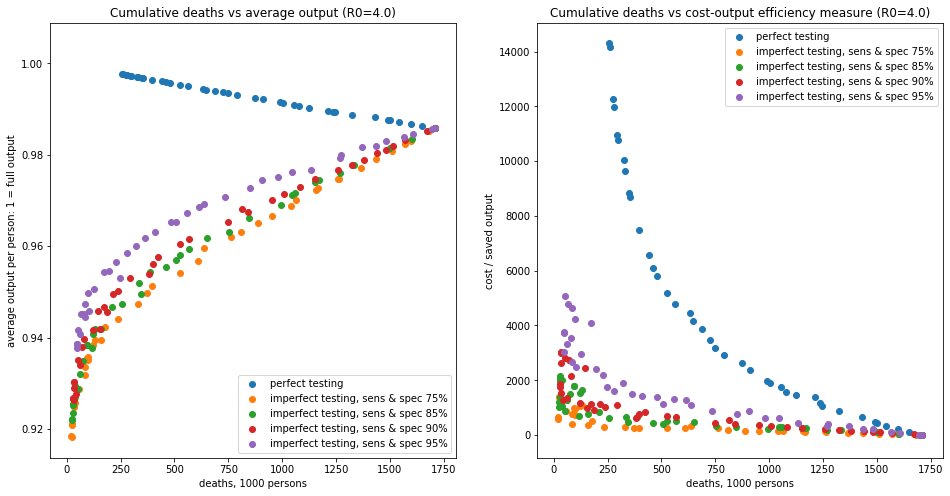

In [105]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
axes[0].scatter(run_obj_df_bc_pt[:,0], -1*run_obj_df_bc_pt[:,1], label='perfect testing'),
axes[0].scatter(run_obj_df_bc_ipt75[:,0], -1*run_obj_df_bc_ipt75[:,1], label='imperfect testing, sens & spec 75%')
axes[0].scatter(run_obj_df_bc_ipt85[:,0], -1*run_obj_df_bc_ipt85[:,1], label='imperfect testing, sens & spec 85%')
axes[0].scatter(run_obj_df_bc_ipt90[:,0], -1*run_obj_df_bc_ipt90[:,1], label='imperfect testing, sens & spec 90%')
axes[0].scatter(run_obj_df_bc_ipt95[:,0], -1*run_obj_df_bc_ipt95[:,1], label='imperfect testing, sens & spec 95%')
axes[0].set_title('Cumulative deaths vs average output (R0=4.0)')
axes[0].set_xlabel('deaths, 1000 persons')
axes[0].set_ylabel('average output per person: 1 = full output')
#axes[0].set_xlim(0,600)
#axes[0].set_ylim(0.975, 1.00)
axes[0].legend()

axes[1].scatter(run_obj_df_bc_pt[:,0],run_obj_df_bc_pt[:,2], label='perfect testing'),
axes[1].scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,2], label='imperfect testing, sens & spec 75%')
axes[1].scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,2], label='imperfect testing, sens & spec 85%')
axes[1].scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,2], label='imperfect testing, sens & spec 90%')
axes[1].scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,2], label='imperfect testing, sens & spec 95%')
axes[1].set_title('Cumulative deaths vs cost-output efficiency measure (R0=4.0)')
axes[1].set_xlabel('deaths, 1000 persons')
axes[1].set_ylabel('cost / saved output')
#axes[1].set_xlim(0,600)
#axes[1].set_ylim(60,140)
axes[1].legend()

fig.savefig("active_results/romer_pareto_imp_testing_R0_4.png", dpi=150)


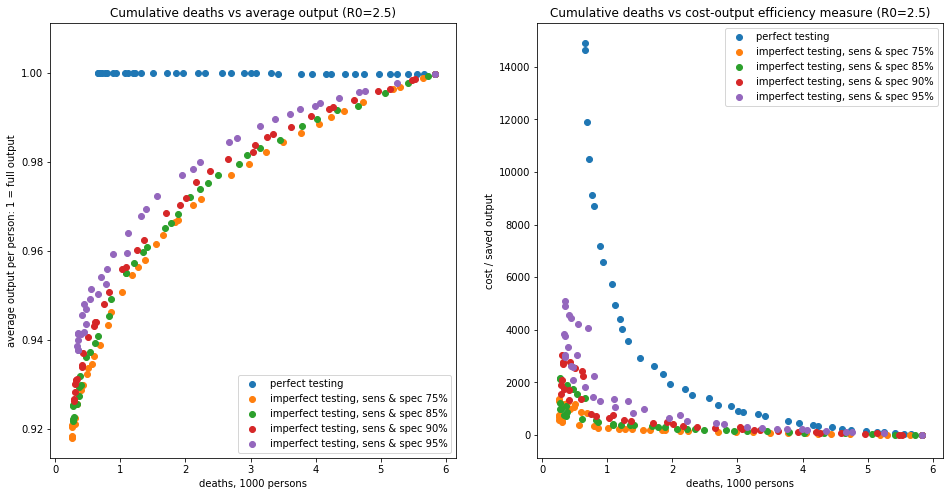

In [108]:
run_obj_df_bc_pt = pd.read_csv('active_results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt75 = pd.read_csv('active_results/romer_sens_spec_075_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt85 = pd.read_csv('active_results/romer_sens_spec_085_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt90 = pd.read_csv('active_results/romer_sens_spec_090_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt95 = pd.read_csv('active_results/romer_sens_spec_095_objectives.csv', delimiter=',').to_numpy()

fig, axes = plt.subplots(ncols=2, figsize=(16,8))
axes[0].scatter(run_obj_df_bc_pt[:,0], -1*run_obj_df_bc_pt[:,1], label='perfect testing'),
axes[0].scatter(run_obj_df_bc_ipt75[:,0], -1*run_obj_df_bc_ipt75[:,1], label='imperfect testing, sens & spec 75%')
axes[0].scatter(run_obj_df_bc_ipt85[:,0], -1*run_obj_df_bc_ipt85[:,1], label='imperfect testing, sens & spec 85%')
axes[0].scatter(run_obj_df_bc_ipt90[:,0], -1*run_obj_df_bc_ipt90[:,1], label='imperfect testing, sens & spec 90%')
axes[0].scatter(run_obj_df_bc_ipt95[:,0], -1*run_obj_df_bc_ipt95[:,1], label='imperfect testing, sens & spec 95%')
axes[0].set_title('Cumulative deaths vs average output (R0=2.5)')
axes[0].set_xlabel('deaths, 1000 persons')
axes[0].set_ylabel('average output per person: 1 = full output')
#axes[0].set_xlim(0,600)
#axes[0].set_ylim(0.975, 1.00)
axes[0].legend()

axes[1].scatter(run_obj_df_bc_pt[:,0],run_obj_df_bc_pt[:,2], label='perfect testing'),
axes[1].scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,2], label='imperfect testing, sens & spec 75%')
axes[1].scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,2], label='imperfect testing, sens & spec 85%')
axes[1].scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,2], label='imperfect testing, sens & spec 90%')
axes[1].scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,2], label='imperfect testing, sens & spec 95%')
axes[1].set_title('Cumulative deaths vs cost-output efficiency measure (R0=2.5)')
axes[1].set_xlabel('deaths, 1000 persons')
axes[1].set_ylabel('cost of testing / reached output')
#axes[1].set_xlim(0,600)
#axes[1].set_ylim(60,140)
axes[1].legend()

fig.savefig("active_results/romer_pareto_imp_testing_R0_4.png", dpi=150)


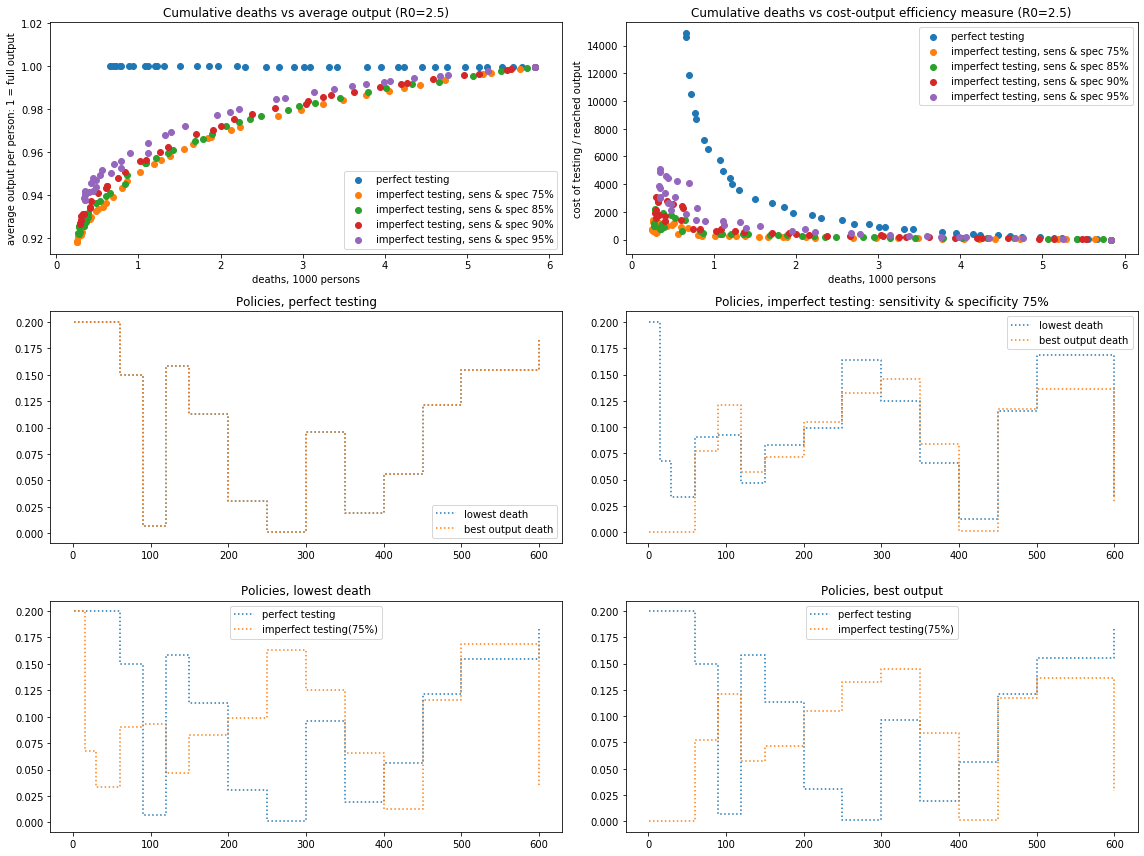

In [118]:
run_obj_df_bc_pt = pd.read_csv('active_results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt75 = pd.read_csv('active_results/romer_sens_spec_075_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt85 = pd.read_csv('active_results/romer_sens_spec_085_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt90 = pd.read_csv('active_results/romer_sens_spec_090_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_ipt95 = pd.read_csv('active_results/romer_sens_spec_095_objectives.csv', delimiter=',').to_numpy()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,12))
axes[0,0].scatter(run_obj_df_bc_pt[:,0], -1*run_obj_df_bc_pt[:,1], label='perfect testing'),
axes[0,0].scatter(run_obj_df_bc_ipt75[:,0], -1*run_obj_df_bc_ipt75[:,1], label='imperfect testing, sens & spec 75%')
axes[0,0].scatter(run_obj_df_bc_ipt85[:,0], -1*run_obj_df_bc_ipt85[:,1], label='imperfect testing, sens & spec 85%')
axes[0,0].scatter(run_obj_df_bc_ipt90[:,0], -1*run_obj_df_bc_ipt90[:,1], label='imperfect testing, sens & spec 90%')
axes[0,0].scatter(run_obj_df_bc_ipt95[:,0], -1*run_obj_df_bc_ipt95[:,1], label='imperfect testing, sens & spec 95%')
axes[0,0].set_title('Cumulative deaths vs average output (R0=2.5)')
axes[0,0].set_xlabel('deaths, 1000 persons')
axes[0,0].set_ylabel('average output per person: 1 = full output')
#axes[0,0].set_xlim(0,600)
#axes[0,0].set_ylim(0.975, 1.00)
axes[0,0].legend()

axes[0,1].scatter(run_obj_df_bc_pt[:,0],run_obj_df_bc_pt[:,2], label='perfect testing'),
axes[0,1].scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,2], label='imperfect testing, sens & spec 75%')
axes[0,1].scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,2], label='imperfect testing, sens & spec 85%')
axes[0,1].scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,2], label='imperfect testing, sens & spec 90%')
axes[0,1].scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,2], label='imperfect testing, sens & spec 95%')
axes[0,1].set_title('Cumulative deaths vs cost-output efficiency measure (R0=2.5)')
axes[0,1].set_xlabel('deaths, 1000 persons')
axes[0,1].set_ylabel('cost of testing / reached output')
#axes[0,1].set_xlim(0,600)
#axes[0,1].set_ylim(60,140)
axes[0,1].legend()

axes[1,0].set_title('Policies, perfect testing')
axes[1,0].step(policy_controls['romer'].testing_policy_control_days, lowest_deaths_policy['romer'][1:len(lowest_deaths_policy['romer'])], ':', where='post', label='lowest death'),
axes[1,0].step(policy_controls['romer'].testing_policy_control_days, best_output_policy['romer'][1:len(best_output_policy['romer'])], ':', where='post', label='best output death'),
axes[1,0].legend()

axes[1,1].set_title('Policies, imperfect testing: sensitivity & specificity 75%')
axes[1,1].step(policy_controls['romer_sens_spec_075'].testing_policy_control_days, lowest_deaths_policy['romer_sens_spec_075'][1:len(lowest_deaths_policy['romer_sens_spec_075'])], ':', where='post', label='lowest death'),
axes[1,1].step(policy_controls['romer_sens_spec_075'].testing_policy_control_days, best_output_policy['romer_sens_spec_075'][1:len(best_output_policy['romer_sens_spec_075'])], ':', where='post', label='best output death'),
axes[1,1].legend()
fig.tight_layout()

axes[2,0].set_title('Policies, lowest death')
axes[2,0].step(policy_controls['romer'].testing_policy_control_days, lowest_deaths_policy['romer'][1:len(lowest_deaths_policy['romer'])], ':', where='post', label='perfect testing'),
axes[2,0].step(policy_controls['romer_sens_spec_075'].testing_policy_control_days, lowest_deaths_policy['romer_sens_spec_075'][1:len(lowest_deaths_policy['romer_sens_spec_075'])], ':', where='post', label='imperfect testing(75%)'),
axes[2,0].legend()

axes[2,1].set_title('Policies, best output')
axes[2,1].step(policy_controls['romer'].testing_policy_control_days, best_output_policy['romer'][1:len(best_output_policy['romer'])], ':', where='post', label='perfect testing'),
axes[2,1].step(policy_controls['romer_sens_spec_075'].testing_policy_control_days, best_output_policy['romer_sens_spec_075'][1:len(best_output_policy['romer_sens_spec_075'])], ':', where='post', label='imperfect testing(75%)'),
axes[2,1].legend()
fig.tight_layout()
#fig.savefig("active_results/romer_pareto_imp_testing_R0_4.png", dpi=150)


## Notes on Romer case with different R0 values
* Note: perfect testing has a different sign slope as imperfect!
* Note: More perfect testing -> more costly per saved _output_ as deaths decrease
* Note: plane formation in cost graph with imperfect tests, might be due to different shapes of control -> CHECK! Also, might be that fronot has not fully converged?
* Thinking: imperfect tests act as strong lockdowns for parts of the tested population. Most / large part of the death preventing effect comes from this 'collateral lockdown'? Here it should be noted that the 'saved output' is really 'cost per output level reached'. The 'saved' output could be calculated from 'no intervention' epidemic case.


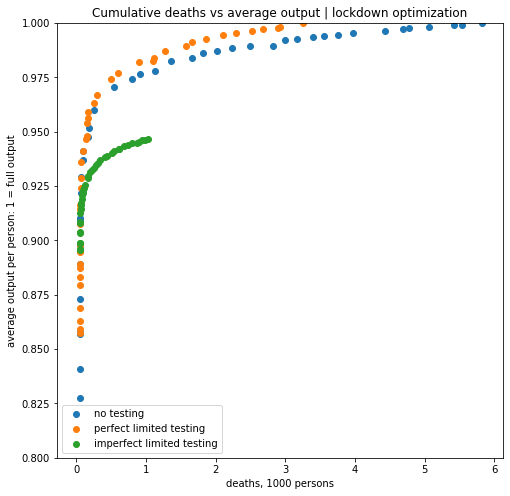

In [109]:
### BASE CASE PARETO
%matplotlib inline
run_obj_df_bc_nt = pd.read_csv('active_results/base_case_lockdown_opt_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_lpt = pd.read_csv('active_results/base_case_lockdown_opt_with_limited_general_testing_objectives.csv', delimiter=',').to_numpy()
run_obj_df_bc_lipt = pd.read_csv('active_results/base_case_lockdown_opt_with_limited_imperfect(0.75)_general_testing_objectives.csv', delimiter=',').to_numpy()

fig, axes = plt.subplots(figsize=(8,8))
axes.scatter(run_obj_df_bc_nt[:,0], -1*run_obj_df_bc_nt[:,1], label='no testing'),
axes.scatter(run_obj_df_bc_lpt[:,0], -1*run_obj_df_bc_lpt[:,1], label='perfect limited testing')
axes.scatter(run_obj_df_bc_lipt[:,0], -1*run_obj_df_bc_lipt[:,1], label='imperfect limited testing')
axes.set_title('Cumulative deaths vs average output | lockdown optimization')
axes.set_xlabel('deaths, 1000 persons')
axes.set_ylabel('average output per person: 1 = full output')
#axes.set_xlim(0,600)
axes.set_ylim(0.8, 1.00)
axes.legend()

fig.savefig("results/base_case_effects_of_testing.png", dpi=150)


## Notes on lockdown optimization with different testing:

* looks like No testing is worse than perfect testing (makes sense) **BUT** imperfect testing lower the effectiveness of lockdown(!). This might be due to false negatives.

In [80]:
lowest_deaths_policy['romer_R0_4.0'][1:len(lowest_deaths_policy['romer_R0_4.0'])]

array([0.2       , 0.0761564 , 0.00983695, 0.06163219, 0.19222668,
       0.01229147, 0.14558483, 0.07242208, 0.18178014, 0.13563139,
       0.18345152, 0.0012994 , 0.05011391, 0.07642487, 0.16386889])

In [75]:
problems['romer_R0_4.0'].testing_policy_control_days

[1, 15, 30, 60, 90, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600]

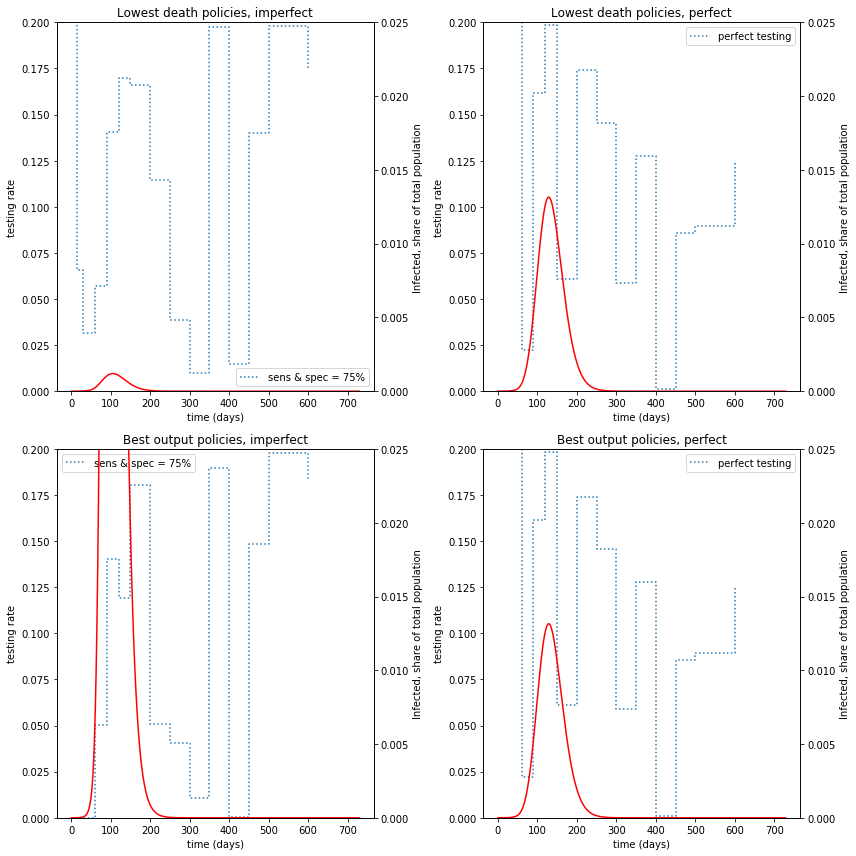

In [81]:
### POLICY PLOTS - ROMER R0=4.0
# max tetst rate 0.2 (!)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

#axes[0].step(problems['romer_R0_4.0'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0'][1:len(lowest_deaths_policy['romer_R0_4.0'])], ':', where='post', label='perfect testing'),
#axes[0].step(problems['romer_R0_4.0_sens_spec_090'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0_sens_spec_090'][1:len(lowest_deaths_policy['romer_R0_4.0_sens_spec_090'])], ':', where='post', label='sens & spec = 90%'),
axes[0,0].step(policy_controls['romer_R0_4.0_sens_spec_075'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0_sens_spec_075'][1:len(lowest_deaths_policy['romer_R0_4.0_sens_spec_075'])], ':', where='post', label='sens & spec = 75%'),

axes[0,0].set_title('Lowest death policies, imperfect')
axes[0,0].set_xlabel('time (days)')
axes[0,0].set_ylabel('testing rate')
#axes[0,0].set_xlim(0,600)
axes[0,0].set_ylim(0.0, 0.2)
secaxy00 = axes[0,0].twinx()
secaxy00.plot(lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][3], color='red')
secaxy00.set_ylim(0.0, 0.025)
secaxy00.set_ylabel('Infected, share of total population')
axes[0,0].legend()

#axes[1].step(problems['romer_R0_4.0'].testing_policy_control_days, best_output_policy['romer_R0_4.0'][1:len(best_output_policy['romer_R0_4.0'])], ':', where='post',label='perfect testing'),
#axes[1].step(problems['romer_R0_4.0_sens_spec_090'].testing_policy_control_days, best_output_policy['romer_R0_4.0_sens_spec_090'][1:len(best_output_policy['romer_R0_4.0_sens_spec_090'])], ':', where='post',label='sens & spec = 90%'),
axes[1,0].step(policy_controls['romer_R0_4.0_sens_spec_075'].testing_policy_control_days, best_output_policy['romer_R0_4.0_sens_spec_075'][1:len(best_output_policy['romer_R0_4.0_sens_spec_075'])], ':', where='post',label='sens & spec = 75%'),
secaxy10 = axes[1,0].twinx()
secaxy10.plot(best_output_run_data['romer_R0_4.0_sens_spec_075'][3], color='red')
secaxy10.set_ylim(0.0, 0.025)
secaxy10.set_ylabel('Infected, share of total population')
axes[1,0].set_title('Best output policies, imperfect')
axes[1,0].set_xlabel('time (days)')
axes[1,0].set_ylabel('testing rate')
#axes[1,0].set_xlim(0,600)
axes[1,0].set_ylim(0.0, 0.2)
axes[1,0].legend()

axes[0,1].step(policy_controls['romer_R0_4.0'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0'][1:len(lowest_deaths_policy['romer_R0_4.0'])], ':', where='post', label='perfect testing'),
#axes[2].step(problems['romer_R0_4.0_sens_spec_090'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0_sens_spec_090'][1:len(lowest_deaths_policy['romer_R0_4.0_sens_spec_090'])], ':', where='post', label='sens & spec = 90%'),
#axes[2].step(problems['romer_R0_4.0_sens_spec_075'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0_sens_spec_075'][1:len(lowest_deaths_policy['romer_R0_4.0_sens_spec_075'])], ':', where='post', label='sens & spec = 75%'),

axes[0,1].set_title('Lowest death policies, perfect')
axes[0,1].set_xlabel('time (days)')
axes[0,1].set_ylabel('testing rate')
#axes[0,1].set_xlim(0,600)
axes[0,1].set_ylim(0.0, 0.2)
secaxy01 = axes[0,1].twinx()
secaxy01.plot(lowest_deaths_run_data['romer_R0_4.0'][3], color='red')
secaxy01.set_ylim(0.0, 0.025)
secaxy01.set_ylabel('Infected, share of total population')
axes[0,1].legend()


axes[1,1].step(policy_controls['romer_R0_4.0'].testing_policy_control_days, best_output_policy['romer_R0_4.0'][1:len(best_output_policy['romer_R0_4.0'])], ':', where='post', label='perfect testing'),
#axes[1,1].step(problems['romer_R0_4.0_sens_spec_090'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0_sens_spec_090'][1:len(lowest_deaths_policy['romer_R0_4.0_sens_spec_090'])], ':', where='post', label='sens & spec = 90%'),
#axes[1,1].step(problems['romer_R0_4.0_sens_spec_075'].testing_policy_control_days, lowest_deaths_policy['romer_R0_4.0_sens_spec_075'][1:len(lowest_deaths_policy['romer_R0_4.0_sens_spec_075'])], ':', where='post', label='sens & spec = 75%'),

axes[1,1].set_title('Best output policies, perfect')
axes[1,1].set_xlabel('time (days)')
axes[1,1].set_ylabel('testing rate')
#axes[1,1].set_xlim(0,600)
axes[1,1].set_ylim(0.0, 0.2)
secaxy11 = axes[1,1].twinx()
secaxy11.plot(best_output_run_data['romer_R0_4.0'][3], color='red')
secaxy11.set_ylim(0.0, 0.025)
secaxy11.set_ylabel('Infected, share of total population')
axes[1,1].legend()

#axes[2].step(problems['romer_R0_4.0'].testing_policy_control_days, most_smooth_policy['romer_R0_4.0'][1:len(most_smooth_policy['romer_R0_4.0'])], ':', where='post', label='perfect testing'),
#axes[2].step(problems['romer_R0_4.0_sens_spec_090'].testing_policy_control_days, most_smooth_policy['romer_R0_4.0_sens_spec_090'][1:len(most_smooth_policy['romer_R0_4.0_sens_spec_090'])], ':', where='post', label='sens & spec = 90%'),
#axes[2].step(problems['romer_R0_4.0_sens_spec_075'].testing_policy_control_days, most_smooth_policy['romer_R0_4.0_sens_spec_075'][1:len(most_smooth_policy['romer_R0_4.0_sens_spec_075'])], ':', where='post', label='sens & spec = 75%'),
#secaxy2 = axes[2].twinx()
#secaxy2.plot(most_smooth_policy_run_data['romer_R0_4.0_sens_spec_075'][3])
#axes[2].set_title('Smoothest policies')
#axes[2].set_xlabel('time (days)')
#axes[2].set_ylabel('testing rate')
#axes[2].set_xlim(0,600)
#axes[2].set_ylim(0.975, 1.00)
#axes[2].legend()

fig.tight_layout()
fig.savefig("results/romer_pareto_imp_testing_R0_4_policies.png", dpi=150)

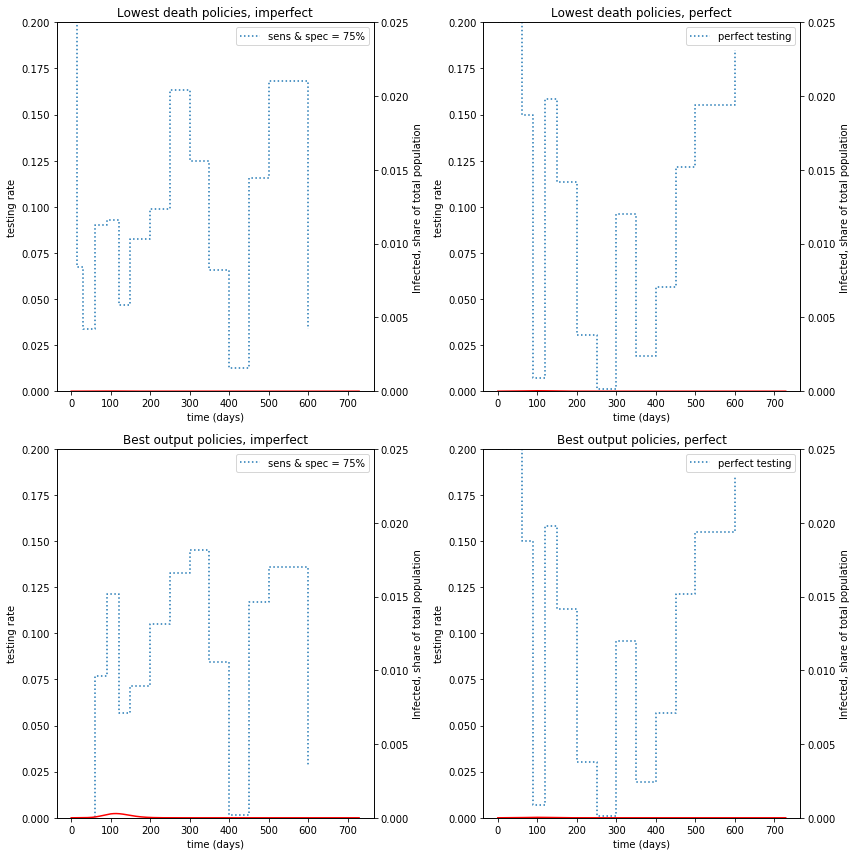

In [82]:
### POLICY PLOTS - ROMER R0=2.5
# max tetst rate 0.05

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

axes[0,0].step(policy_controls['romer_sens_spec_075'].testing_policy_control_days, lowest_deaths_policy['romer_sens_spec_075'][1:len(lowest_deaths_policy['romer_sens_spec_075'])], ':', where='post', label='sens & spec = 75%'),
axes[0,0].set_title('Lowest death policies, imperfect')
axes[0,0].set_xlabel('time (days)')
axes[0,0].set_ylabel('testing rate')
#axes[0,0].set_xlim(0,600)
axes[0,0].set_ylim(0.0, 0.2)
secaxy00 = axes[0,0].twinx()
secaxy00.plot(lowest_deaths_run_data['romer_sens_spec_075'][3], color='red')
secaxy00.set_ylim(0.0, 0.025)
secaxy00.set_ylabel('Infected, share of total population')
axes[0,0].legend()

axes[1,0].step(policy_controls['romer_sens_spec_075'].testing_policy_control_days, best_output_policy['romer_sens_spec_075'][1:len(best_output_policy['romer_sens_spec_075'])], ':', where='post',label='sens & spec = 75%'),
secaxy10 = axes[1,0].twinx()
secaxy10.plot(best_output_run_data['romer_sens_spec_075'][3], color='red')
secaxy10.set_ylim(0.0, 0.025)
secaxy10.set_ylabel('Infected, share of total population')
axes[1,0].set_title('Best output policies, imperfect')
axes[1,0].set_xlabel('time (days)')
axes[1,0].set_ylabel('testing rate')
#axes[1,0].set_xlim(0,600)
axes[1,0].set_ylim(0.0, 0.2)
axes[1,0].legend()

axes[0,1].step(policy_controls['romer'].testing_policy_control_days, lowest_deaths_policy['romer'][1:len(lowest_deaths_policy['romer'])], ':', where='post', label='perfect testing'),
axes[0,1].set_title('Lowest death policies, perfect')
axes[0,1].set_xlabel('time (days)')
axes[0,1].set_ylabel('testing rate')
#axes[0,1].set_xlim(0,600)
axes[0,1].set_ylim(0.0, 0.2)
secaxy01 = axes[0,1].twinx()
secaxy01.plot(lowest_deaths_run_data['romer'][3], color='red')
secaxy01.set_ylim(0.0, 0.025)
secaxy01.set_ylabel('Infected, share of total population')
axes[0,1].legend()


axes[1,1].step(policy_controls['romer'].testing_policy_control_days, best_output_policy['romer'][1:len(best_output_policy['romer'])], ':', where='post', label='perfect testing'),
axes[1,1].set_title('Best output policies, perfect')
axes[1,1].set_xlabel('time (days)')
axes[1,1].set_ylabel('testing rate')
#axes[1,1].set_xlim(0,600)
axes[1,1].set_ylim(0.0, 0.2)
secaxy11 = axes[1,1].twinx()
secaxy11.plot(best_output_run_data['romer'][3], color='red')
secaxy11.set_ylim(0.0, 0.025)
secaxy11.set_ylabel('Infected, share of total population')
axes[1,1].legend()


fig.tight_layout()
fig.savefig("results/romer_pareto_imp_testing_policies.png", dpi=150)

### Effects of delay between infection and symptoms:

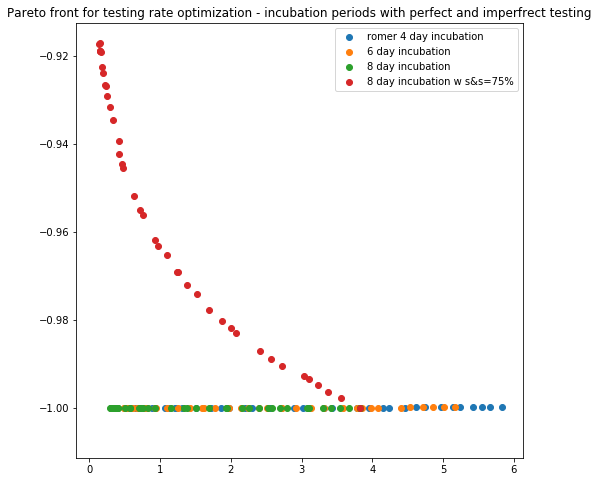

In [102]:

#run_obj_df_bc = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer = pd.read_csv('active_results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_6incu = pd.read_csv('active_results/romer_6d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu = pd.read_csv('active_results/romer_8d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu_ss75 = pd.read_csv('active_results/romer_8d_incubation_sens_spec_075_objectives.csv', delimiter=',').to_numpy()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
plt.scatter(run_obj_df_romer[:,0], run_obj_df_romer[:,1])
plt.scatter(run_obj_df_romer_6incu[:,0], run_obj_df_romer_6incu[:,1])
plt.scatter(run_obj_df_romer_8incu[:,0], run_obj_df_romer_8incu[:,1])
plt.scatter(run_obj_df_romer_8incu_ss75[:,0], run_obj_df_romer_8incu_ss75[:,1])

plt.legend(['romer 4 day incubation', '6 day incubation', '8 day incubation', '8 day incubation w s&s=75%'])
plt.title("Pareto front for testing rate optimization - incubation periods with perfect and imperfrect testing")
plt.savefig("results/romer_incubation_pareto.png", dpi=150)
plt.show()


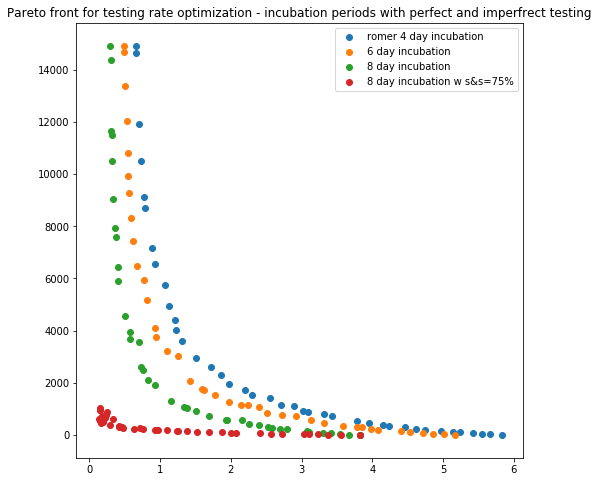

In [101]:

#run_obj_df_bc = pd.read_csv('results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer = pd.read_csv('active_results/romer_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_6incu = pd.read_csv('active_results/romer_6d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu = pd.read_csv('active_results/romer_8d_incubation_objectives.csv', delimiter=',').to_numpy()
run_obj_df_romer_8incu_ss75 = pd.read_csv('active_results/romer_8d_incubation_sens_spec_075_objectives.csv', delimiter=',').to_numpy()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#ax.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1], run_obj_df_bc[:,2])
plt.scatter(run_obj_df_romer[:,0], run_obj_df_romer[:,2])
plt.scatter(run_obj_df_romer_6incu[:,0], run_obj_df_romer_6incu[:,2])
plt.scatter(run_obj_df_romer_8incu[:,0], run_obj_df_romer_8incu[:,2])
plt.scatter(run_obj_df_romer_8incu_ss75[:,0], run_obj_df_romer_8incu_ss75[:,2])

plt.legend(['romer 4 day incubation', '6 day incubation', '8 day incubation', '8 day incubation w s&s=75%'])
plt.title("Pareto front for testing rate optimization - incubation periods with perfect and imperfrect testing")
plt.savefig("results/romer_incubation_pareto.png", dpi=150)
plt.show()


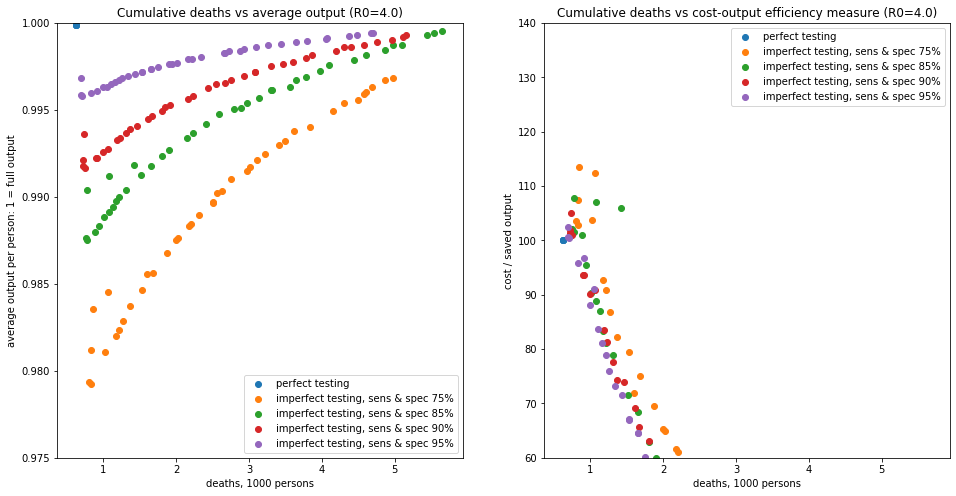

In [85]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
axes[0].scatter(run_obj_df_bc_pt[:,0], -1*run_obj_df_bc_pt[:,1], label='perfect testing'),
axes[0].scatter(run_obj_df_bc_ipt75[:,0], -1*run_obj_df_bc_ipt75[:,1], label='imperfect testing, sens & spec 75%')
axes[0].scatter(run_obj_df_bc_ipt85[:,0], -1*run_obj_df_bc_ipt85[:,1], label='imperfect testing, sens & spec 85%')
axes[0].scatter(run_obj_df_bc_ipt90[:,0], -1*run_obj_df_bc_ipt90[:,1], label='imperfect testing, sens & spec 90%')
axes[0].scatter(run_obj_df_bc_ipt95[:,0], -1*run_obj_df_bc_ipt95[:,1], label='imperfect testing, sens & spec 95%')
axes[0].set_title('Cumulative deaths vs average output (R0=4.0)')
axes[0].set_xlabel('deaths, 1000 persons')
axes[0].set_ylabel('average output per person: 1 = full output')
#axes[0].set_xlim(0,600)
axes[0].set_ylim(0.975, 1.00)
axes[0].legend()

axes[1].scatter(run_obj_df_bc_pt[:,0],run_obj_df_bc_pt[:,2], label='perfect testing'),
axes[1].scatter(run_obj_df_bc_ipt75[:,0], run_obj_df_bc_ipt75[:,2], label='imperfect testing, sens & spec 75%')
axes[1].scatter(run_obj_df_bc_ipt85[:,0], run_obj_df_bc_ipt85[:,2], label='imperfect testing, sens & spec 85%')
axes[1].scatter(run_obj_df_bc_ipt90[:,0], run_obj_df_bc_ipt90[:,2], label='imperfect testing, sens & spec 90%')
axes[1].scatter(run_obj_df_bc_ipt95[:,0], run_obj_df_bc_ipt95[:,2], label='imperfect testing, sens & spec 95%')
axes[1].set_title('Cumulative deaths vs cost-output efficiency measure (R0=4.0)')
axes[1].set_xlabel('deaths, 1000 persons')
axes[1].set_ylabel('cost / saved output')
#axes[1].set_xlim(0,600)
axes[1].set_ylim(60,140)
axes[1].legend()

fig.savefig("results/romer_pareto_imp_testing_R0_4.png", dpi=150)

### Analysis on effects of imperfect testing in Romer case

With perfect testing the optimal solution converges approximately towards a single point. Lowering testing rate could lower costs, but at the same time this would risk more deaths and lower the saved output. On the other hand, with a certain profile, the more testing will do little good, but would generate more costs. 

With imperfect testing, more tests will lead to false positives and false negatives, which will then create tradeoffs. A great number of false positives will lead to reduced output. Thus, increasing testing in a low infectious population situation, will lower deaths but increase the number of people in quarantine without good reason. However, when the population contains many infected persons, the benefits are clear.

How low deaths can be pushed just by testing is dependent on the true positive rate, i.e. sensitivity. If the test has <1.0 sensitivity, some subjects will always gett false negative results, and end up spreading the disease without anybody knowing about it.

In [86]:
plt.figure(figsize=(8,8))
plt.scatter(run_obj_df_bc[:,0], run_obj_df_bc[:,1])

NameError: name 'run_obj_df_bc' is not defined

<Figure size 576x576 with 0 Axes>

time stteps size:  range(0, 730)


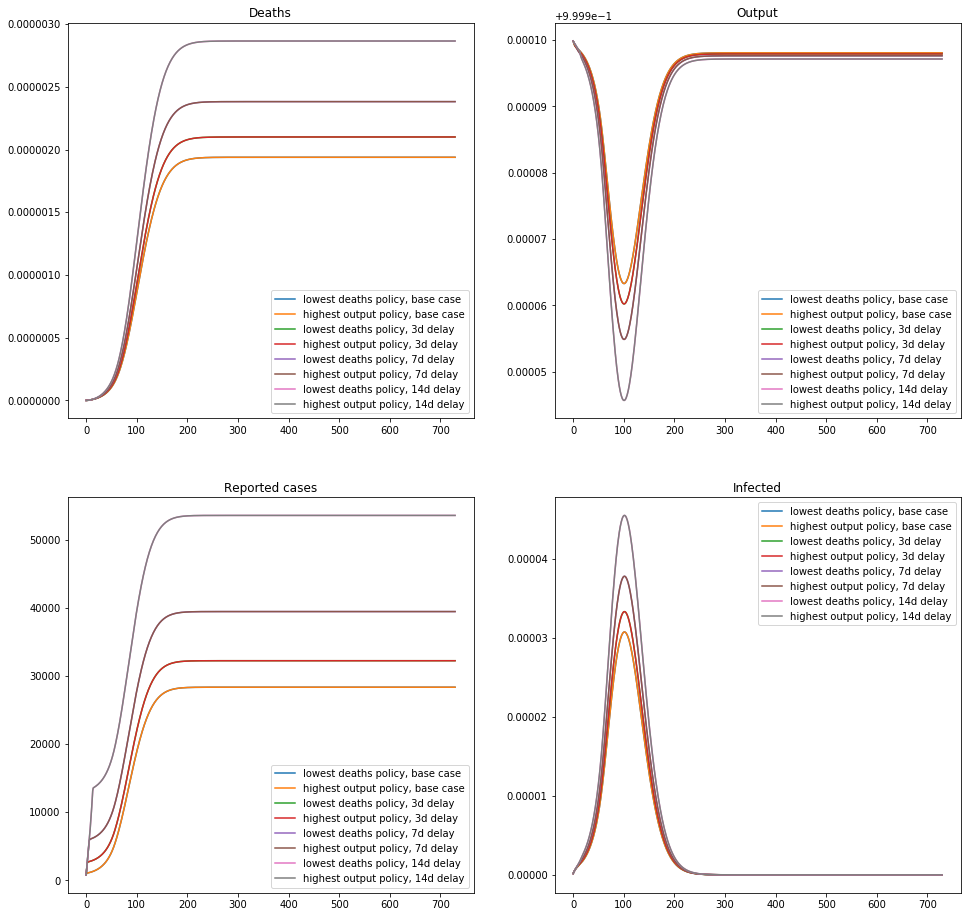

In [99]:
# EFFECTS OF DELAY on ROMER CASE

time_steps = range(0, epidemic_simulators['romer'][0].T_years*365)
print("time stteps size: ", time_steps)

plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
plt.plot(time_steps, best_output_run_data['romer'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][7])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][7])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][7])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][7])
plt.title("Deaths")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])

plt.subplot(222)
plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
plt.plot(time_steps, best_output_run_data['romer'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][11])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][11])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][11])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][11])
plt.title("Output")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])

plt.subplot(223)
plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
plt.plot(time_steps, best_output_run_data['romer'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][0])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][0])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][0])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][0])
plt.title("Reported cases")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])

plt.subplot(224)
plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
plt.plot(time_steps, best_output_run_data['romer'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_3d_delay'][3])
plt.plot(time_steps, best_output_run_data['romer_3d_delay'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_7d_delay'][3])
plt.plot(time_steps, best_output_run_data['romer_7d_delay'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_14d_delay'][3])
plt.plot(time_steps, best_output_run_data['romer_14d_delay'][3])
plt.title("Infected")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, 3d delay', 'highest output policy, 3d delay', 'lowest deaths policy, 7d delay', 'highest output policy, 7d delay', 'lowest deaths policy, 14d delay', 'highest output policy, 14d delay' ])


#plt.tight_layout()
plt.show()

In [81]:
lowest_deaths_run_data

{'romer': (array([  54.12240319,  109.90625729,  164.2530567 ,  218.1372533 ,
          272.39296147,  327.75119446,  384.8650375 ,  444.32927901,
          506.69644801,  572.49014572,  642.21624939,  716.3724292 ,
          795.45633183,  879.97271876,  970.43979501, 1037.65030384,
         1072.5979211 , 1090.52353088, 1099.6308914 , 1104.23757249,
         1106.56558609, 1107.74319864, 1108.33992075, 1108.6428582 ,
         1108.79691183, 1108.87536458, 1108.91536237, 1108.93577239,
         1108.94619407, 1108.95151817, 1108.95543619, 1108.95953258,
         1108.96381798, 1108.96830311, 1108.97299889, 1108.97791651,
         1108.9830675 , 1108.98846378, 1108.99411769, 1109.00004208,
         1109.00625034, 1109.0127564 , 1109.01957485, 1109.02672091,
         1109.03421051, 1109.04206031, 1109.05028775, 1109.05891109,
         1109.06794948, 1109.07742293, 1109.08735246, 1109.09776004,
         1109.10866874, 1109.1201027 , 1109.13208723, 1109.14464887,
         1109.15781541, 1

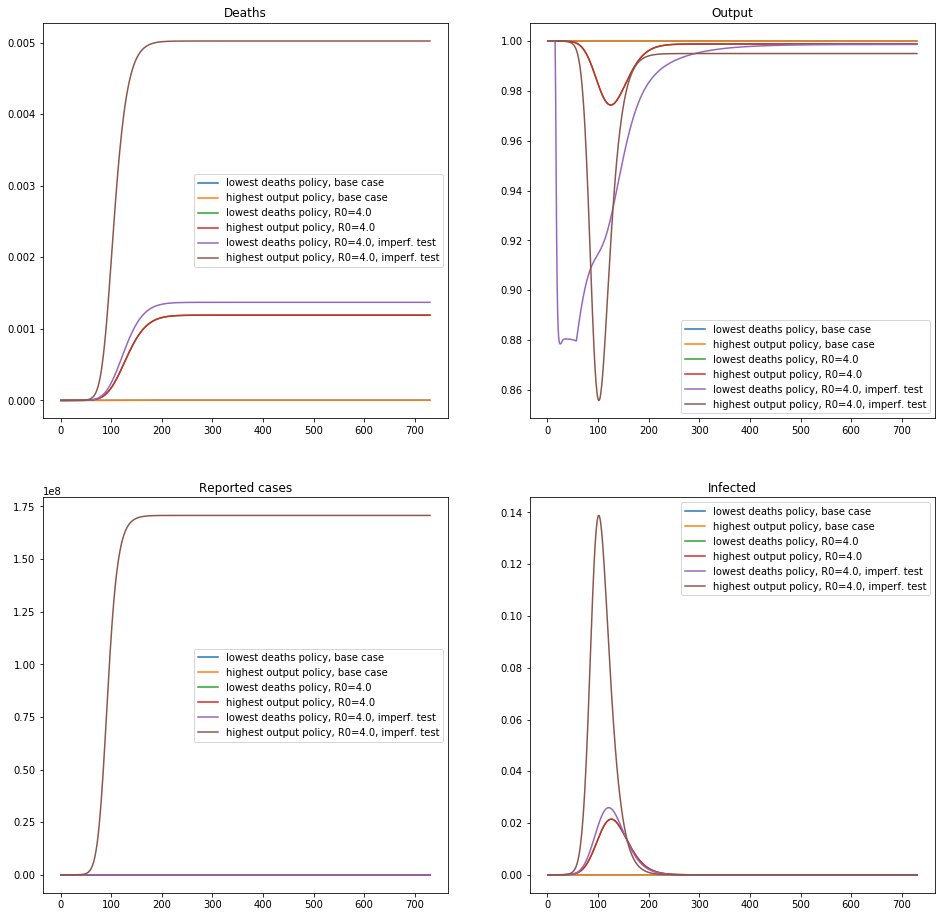

In [46]:
# EFFECTS OF R0 on ROMER CASE

plt.figure(figsize=(16,16))
'romer_R0_4.0_sens_spec_075'
plt.subplot(221)
plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
plt.plot(time_steps, best_output_run_data['romer'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.title("Deaths")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(222)
plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
plt.plot(time_steps, best_output_run_data['romer'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.title("Output")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(223)
plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
plt.plot(time_steps, best_output_run_data['romer'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.title("Reported cases")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(224)
plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
plt.plot(time_steps, best_output_run_data['romer'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.title("Infected")
plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])


#plt.tight_layout()
plt.show()

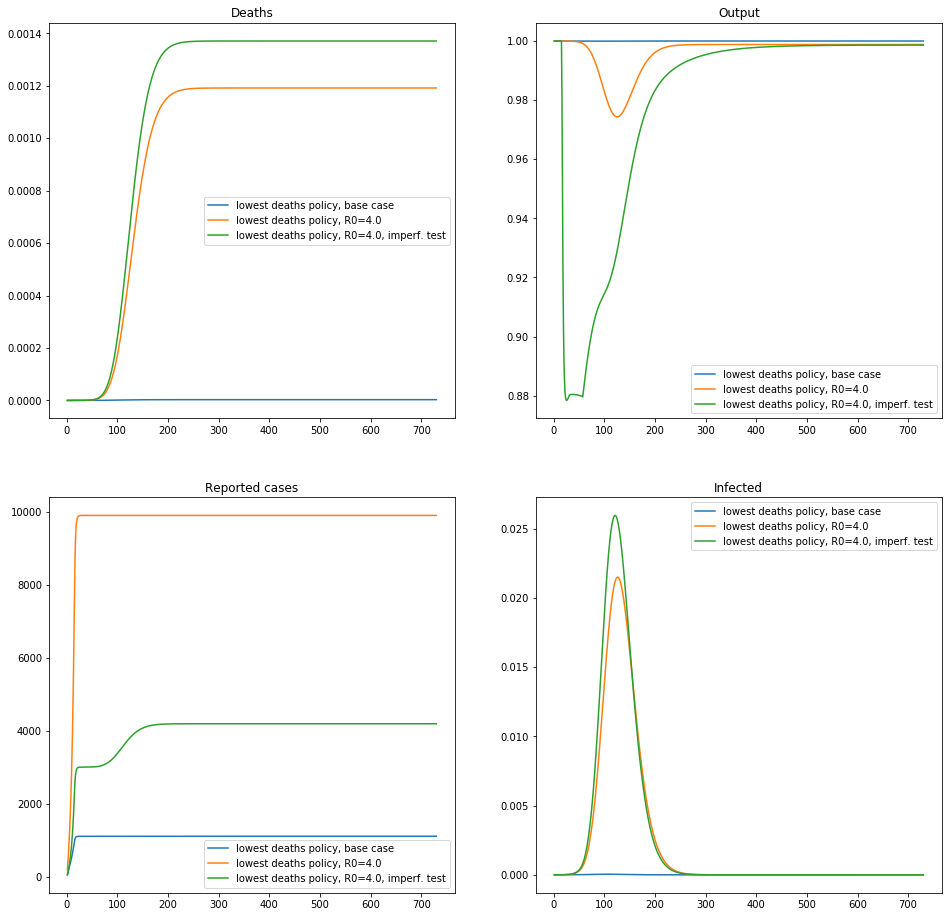

In [49]:
# EFFECTS OF R0 on ROMER CASE

plt.figure(figsize=(16,16))
'romer_R0_4.0_sens_spec_075'
plt.subplot(221)
plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
#plt.plot(time_steps, best_output_run_data['romer'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][7])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][7])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.title("Deaths")
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])

plt.subplot(222)
plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
#plt.plot(time_steps, best_output_run_data['romer'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][11])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][11])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.title("Output")
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])

plt.subplot(223)
plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
#plt.plot(time_steps, best_output_run_data['romer'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][0])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][0])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.title("Reported cases")
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])

plt.subplot(224)
plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
#plt.plot(time_steps, best_output_run_data['romer'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][3])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][3])
#plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.title("Infected")
#plt.legend(['lowest deaths policy, base case', 'highest output policy, base case', 'lowest deaths policy, R0=4.0', 'highest output policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test', 'highest output policy, R0=4.0, imperf. test' ])
plt.legend(['lowest deaths policy, base case', 'lowest deaths policy, R0=4.0', 'lowest deaths policy, R0=4.0, imperf. test'])


#plt.tight_layout()
plt.show()

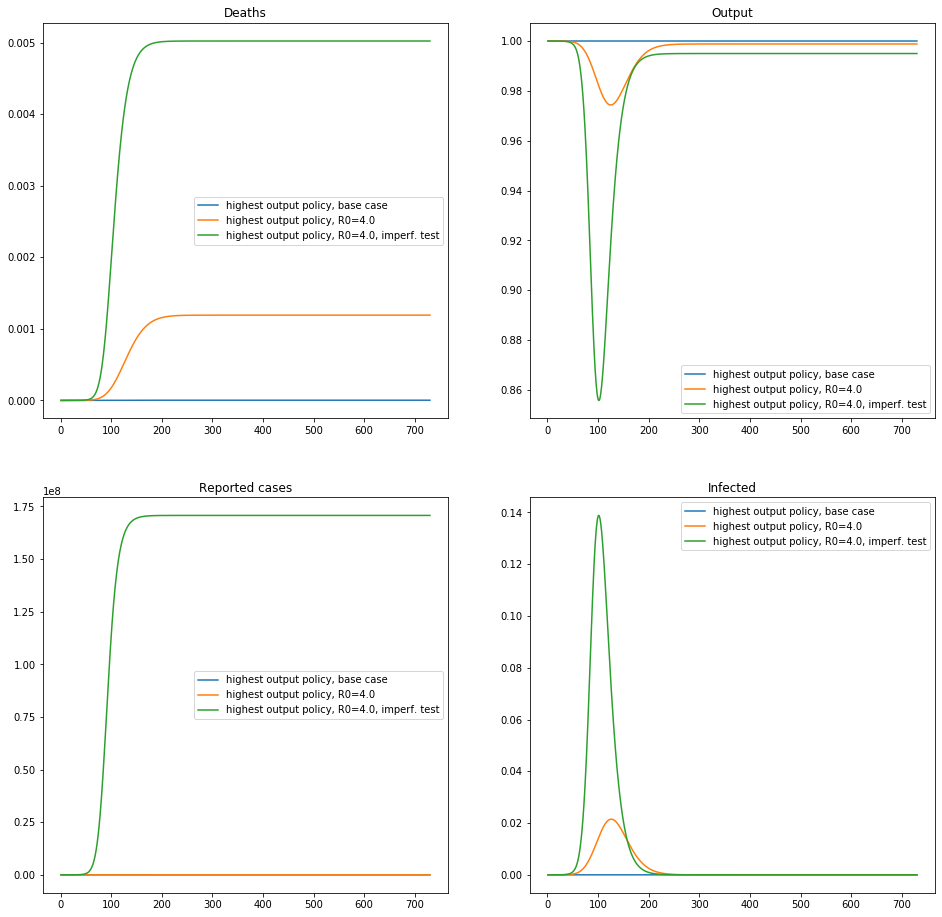

In [50]:
# EFFECTS OF R0 on ROMER CASE

plt.figure(figsize=(16,16))
'romer_R0_4.0_sens_spec_075'
plt.subplot(221)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][7])
plt.plot(time_steps, best_output_run_data['romer'][7])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][7])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][7])
plt.title("Deaths")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(222)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][11])
plt.plot(time_steps, best_output_run_data['romer'][11])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][11])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][11])
plt.title("Output")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(223)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][0])
plt.plot(time_steps, best_output_run_data['romer'][0])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][0])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][0])
plt.title("Reported cases")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])

plt.subplot(224)
#plt.plot(time_steps, lowest_deaths_run_data['romer'][3])
plt.plot(time_steps, best_output_run_data['romer'][3])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0'][3])
#plt.plot(time_steps, lowest_deaths_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.plot(time_steps, best_output_run_data['romer_R0_4.0_sens_spec_075'][3])
plt.title("Infected")
plt.legend(['highest output policy, base case', 'highest output policy, R0=4.0', 'highest output policy, R0=4.0, imperf. test' ])


#plt.tight_layout()
plt.show()

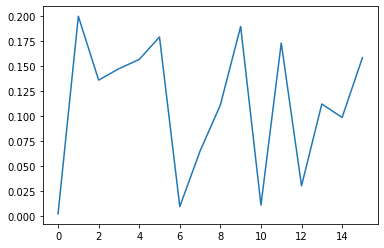

In [59]:
plt.figure()
plt.plot(best_output_policy['romer'])